In [1]:
#select where to run this notebook---
binder_or_localpc=True #True: if you want to run the script using binder or in your local PC
google_colab=False #True: if you want to run the script in google colab

In [2]:
%%capture
#!pip freeze. #to list the packages installed in colab
#or install without checking above (!but do it just once)---
#select these versions to avoid compatibility issues in Colab
if google_colab:
    !pip install "numpy==1.24.4"
    !pip install "matplotlib==3.7.1" #Install matplotlib 3.7 or greater (known to have fix)
    !pip install "xarray==2023.1.0"
    !pip install "pyproj==3.5.0"
    !pip install "scipy==1.10.1"
    !pip install tqdm

In [3]:
#open packages---
import numpy as np
import xarray as xr
from tqdm import tqdm
import os
import sys
from matplotlib import path
import matplotlib.pyplot as plt
import matplotlib as mpl
#for projections
from pyproj import Transformer 

In [4]:
#modify the local path in case you run this script in your computer---
if binder_or_localpc:
    dir_main="../"
if google_colab:
    #google colab path:
    mount_point='/content/gdrive/' #dir name for a temporal mount point (just for running this script)
    gdrive_path="MyDrive/colab_repos/" #the path in "my Google Drive" where you have cloned the repo
    dir_main=mount_point+gdrive_path
    #mount:
    from google.colab import drive
    drive.mount(mount_point)

In [5]:
#don't modify below paths---
#name of the repository:
if binder_or_localpc: 
    dir_repo=""
if google_colab:
    #name of directories from the cloned github repo:
    dir_repo="paper_Efficient_Deep_Learning_Surrogate_Method_For_Lagrangian_Transport/"
dir_data="data/"
dir_functions="functions/"
dir_figures="figures/"
dir_output="output/"
#name of files with data:
file_advection_dispersion_for_optimal_prediction="file_advection_dispersion_for_optimal_prediction.nc"
file_advection_dispersion_for_surrogate_prediction="file_advection_dispersion_for_surrogate_prediction.nc"
file_bathymetry="dws_bathymetry_200x200m.nc"
file_dws_particles_bound_400m=f"dws_particle_boundaries_400x400m.nc"
file_dws_bound="dws_boundaries_200x200m.nc" 

In [6]:
#import helper functions---
sys.path.append(dir_main+dir_repo+dir_functions)
from helpers_for_running_simplified_LPTM import xr_eig, xr_matmul, get_inout_particles_dws, save_particle_positions
from helpers_for_plotting import get_statistics, save_statistics, get_bins, binning_particles, transform_coordinates, create_cmap

In [7]:
#create dir figures if it does not exists---
if not os.path.exists(dir_main+dir_repo+dir_figures):
    os.makedirs(dir_main+dir_repo+dir_figures)

In [8]:
#set global parameters for figures---
glob_font_size=11
params = {'legend.fontsize':glob_font_size-2,
          'axes.titlesize':glob_font_size,'axes.labelsize': glob_font_size, #size of titles, x-y labels 
          'xtick.labelsize':glob_font_size-1,'ytick.labelsize':glob_font_size-1, #size of xtick-labels, ytick-labels
          'xtick.major.size':2,'xtick.major.width':.8, #length and width of xticks marks
          'ytick.major.size':2,'ytick.major.width':.8,} #length and width of yticks marks
mpl.rcParams.update(params)

## 1) Compute the residual evolution of a patch for the Optimal and Surrogate prediction (windy period of Figure 5)

In [9]:
#Inputs----
#set tracking time:
#with the small set of data provided for this example: tracking_time < 15 tidal periods
tracking_time=14 #(integer) tracking time in tidal periods
tidal_period=44714 #(seconds) the duration of the tidal period used to compute adevection and dispersion = (12.42h + 2s)

#properties of the particle patch:
#you can choose any other point within the DWS boundaries 
patch_center_point_lat=53.075; patch_center_point_lon=5.1 #(latitude, longitude) center point of the patch within the DWS 
dx_patch=dy_patch=2 #(m) resolution of the particles within the patch: release one particle in the center of every (dx_patch)x(dy_patch) cell within the patch of (length_patch)x(length_patch) size
length_patch=800 #(m) length of the square that represents the borders of the patch

#define more inputs:
typevar='float32' #precision to speed up computations (no significant difference if working with float64) 
dx_getm=200; dy_getm=200 #(m) resolution of GETM-DWS simulation 

#names coast and islands:
names_boundaries=["coast","texel","vlieland","terschelling","ameland","schiermonnikoog"]

In [10]:
#open data------

#open topography file with the original 200x200m GETM resolution
ds_topography=xr.open_dataset(dir_main+dir_repo+dir_data+file_bathymetry)

#open DWS particles boundaries for 400x400m domain
ds_boundaries_400m=xr.open_dataset(dir_main+dir_repo+dir_data+file_dws_particles_bound_400m) #open contour of land based on particles boundaries (the only difference with above is for the mainland)
boundaries_dws_par_400m=ds_boundaries_400m.bdr_dws.values

#open a small dataset of advection (A) and dispersion (D) for the optimal prediction
ds_adv_disp_optimal_prediction=xr.open_dataset(dir_main+dir_repo+dir_data+file_advection_dispersion_for_optimal_prediction)

#open a small dataset of advection and dispersion for the surrogate prediction
#these are outputs from the trained ConvLSTM models of A and D
ds_adv_disp_surrogate_prediction=xr.open_dataset(dir_main+dir_repo+dir_data+file_advection_dispersion_for_surrogate_prediction)

In [11]:
#select the first deployment date (this corresponds to the windy case of Figure 5)----
#with the provided dataset you can only select until the next deployment it=1 when tracking_time = 14
it=0 #first deployment 
time_deployment=[ds_adv_disp_optimal_prediction.time[it].values] 
time_deployment

[numpy.datetime64('2015-11-27T21:37:54.000000000')]

In [12]:
#get a square particle patch around its center point defined by (lat,lon)---
def create_particle_patch(patch_center_point_lat, patch_center_point_lon, dx_patch, dy_patch, length_patch, xgrid, ygrid, ds_topography, boundaries_dws, dx_getm, dy_getm, typevar):
    """
    create the initial particle patch
    
    Returns:
    -------
     - initial_particle_coords: numpy.ndarray 
                                x,y coordinates (m) of the particles within the patch (N,2).
                                N = number of particles (160000 for the default example) 
                                x,y are deefined along the axes of the GETM-DWS setup
    """
    #define the transformations-------
    #convert from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
    proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
    #convert from epgs:4326(LatLon with WGS84) to epgs:28992(DWS)
    inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)

    #convert lon,lat to 28992(DWS)-projection---------
    #for the bathymetry---
    xctp,yctp,z = inproj.transform(ds_topography.lonc.values,ds_topography.latc.values,ds_topography.latc.values*0.)
    xctp=xctp; yctp=yctp #(m)
    xctp0=xctp[0,0]; yctp0=yctp[0,0] #first projected point of the model axes
    #for the center point of the patch---
    patch_center_point_xp,patch_center_point_yp,z = inproj.transform(patch_center_point_lon,patch_center_point_lat,0.)
    patch_center_point_xp=patch_center_point_xp
    patch_center_point_yp=patch_center_point_yp

    #convert 28992(DWS)-projection to model axes----------
    #matrix rotation 17degrees---
    #the GETM model axes are rotated +17deg with respect to the east
    ang=17*np.pi/180
    angs=np.ones((2,2))
    angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
    angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)
    #for the bathymetry---    
    xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
    xyl=np.matmul(angs,xy.T).T
    xyl0=xyl[0,:] #the first point after rotation
    xc,yc = ds_topography.xc,ds_topography.yc  #x,y center positions of the GETM grid
    xyc0=np.c_[xc.min().values,yc.min().values] #=0,0
    #for the center point of the patch---
    patch_center_point_xyp=np.c_[patch_center_point_xp,patch_center_point_yp] 
    patch_center_point_xy=np.matmul(angs,patch_center_point_xyp.T).T #rotate
    patch_center_point_xy=np.squeeze(patch_center_point_xy-xyl0+xyc0) #correct
    
    #set particles inside the patch----------------
    
    #match the center point of the patch to the nearest point of the grid of advection and dispersion---
    xgrid,ygrid=np.meshgrid(xgrid,ygrid)
    dis=((patch_center_point_xy[0]-xgrid)**2+(patch_center_point_xy[1]-ygrid)**2)**.5
    iy,ix=np.where(dis==dis.min()); iy=iy[0]; ix=ix[0]
    patch_center_point_xy=[xgrid[0,ix], ygrid[iy,0]] #new center of square patch in local model coords
    
    #create the coordinates of the borders of the patch (ccw oriented)---
    x0=patch_center_point_xy[0];y0=patch_center_point_xy[1]
    border_patch_x=np.array([x0-length_patch/2,x0+length_patch/2,x0+length_patch/2,x0-length_patch/2,x0-length_patch/2])
    border_patch_y=np.array([y0-length_patch/2,y0-length_patch/2,y0+length_patch/2,y0+length_patch/2,y0-length_patch/2])

    #build grid of (dx_patch)x(dy_patch) around the patch---
    nx=int(length_patch/dx_getm)+10; ny=int(length_patch/dy_getm)+10 
    xi=xgrid[0,ix-nx]-dx_getm/2+dx_patch/2; yi=ygrid[iy-ny,0]-dy_getm/2+dy_patch/2 
    xe=xgrid[0,ix+nx]+dx_getm/2-dx_patch/2; ye=ygrid[iy+ny,0]+dy_getm/2-dy_patch/2
    initial_particle_coords_x=np.arange(xi,xe+dx_patch,dx_patch)
    initial_particle_coords_y=np.arange(yi,ye+dy_patch,dy_patch)
    initial_particle_coords_x, initial_particle_coords_y = np.meshgrid(initial_particle_coords_x, initial_particle_coords_y)
    initial_particle_coords_x=initial_particle_coords_x.flatten()
    initial_particle_coords_y=initial_particle_coords_y.flatten()

    #find particles inside the square patch---
    radius=1e-10 #our square is ccw, so expand
    #to expand contour: if ccw (radius>0);  if cw=0 (radius<0)
    #to shrink contour: if ccw (radius<0);  if cw=0 (radius>0)
    #
    #path along the borders of the patch       
    path_border_patch=path.Path(np.c_[border_patch_x,border_patch_y],closed=True)
    #select the particles inside the patch
    initial_particle_coords=np.c_[initial_particle_coords_x,initial_particle_coords_y] #(N,2)
    index = path_border_patch.contains_points(initial_particle_coords,radius=radius) #index=True particles inside
    initial_particle_coords=initial_particle_coords[index,:]
    #select the particles inside dws---
    path_border_dws=path.Path(boundaries_dws,closed=True)
    index = path_border_dws.contains_points(initial_particle_coords,radius=radius) #points inside
    initial_particle_coords=initial_particle_coords[index,:]
    print(f"particles inside DWS: {len(initial_particle_coords[:,0])}")
    initial_particle_coords = initial_particle_coords.astype(typevar) #(m)
    #
    return  initial_particle_coords


#get sigma matrix for Eq. (4) based on eigenvalues and eigenvectors of the dispersion tensor---
def sigma_matrix(ds_adv_disp, typevar):
    """
    create the sigma matrix for Eq. (4) of the paper Fajardo-Urbina et al. (2024)
    
    Parameters:
    -------
     - ds_adv_disp: xr.Dataset (time,y,x)
                    Dataset with advection an dispersion to use as input to our simplified Lagrangian model:  Eq. (4)
                    x,y are the center position of the 400x400m patches used to compute advection and dispersion
              
    Returns:
    ---------
     - ds_sig: xr.DataArray (time,y,x,2,2)
               the sigma matrix of Eq. (4) for every position x,y and time
               the units are in m and in the local axis of the GETM-DWS coordinates
    """    
    #eigenvals and vecs from dispersion---
    ds_disp=xr.concat([(ds_adv_disp[f'dispxx']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                      (ds_adv_disp[f'dispxy']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    ds_disp1=xr.concat([(ds_adv_disp[f'dispxy']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                      (ds_adv_disp[f'dispyy']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    ds_disp=xr.concat([ds_disp,ds_disp1],dim='a'); del ds_disp1
    #compute eigenvals and eigenvec
    eigenvals,eigenvect=xr_eig(ds_disp,dims=['a','b']) #set nan=0, as it does not work for nan
    #set to 0 eigenvalues<0. This is neccesary for the ML case since this is not formally a covariance matrix, so negative eigenvalues can appear
    eigenvals=eigenvals.where(eigenvals>=0,0)
    #create 2d array for eigenval
    eigenval=xr.concat([eigenvals.isel(b=0).expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                         0.*eigenvals.isel(b=0).expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    eigenval1=xr.concat([0.*eigenvals.isel(b=1).expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                       eigenvals.isel(b=1).expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    eigenval=xr.concat([eigenval,eigenval1],dim='a')
    #create sigma array
    ds_sig = (xr_matmul( xr_matmul(eigenvect,(eigenval)**.5,['a','b'],['a','b']), eigenvect.transpose('time', 'yc', 'xc', 'b','a') ,['a','b'],['b','a'])).rename({'a2':'b'})
    #
    return ds_sig.astype(typevar)


#get particle trajectories using Eq. (4)----
def get_particle_trajectories(ds_adv_disp, ds_sig_disp ,time_deployment, tracking_time, tidal_period, initial_particle_coords, anti_beaching, names_boundaries, ds_boundaries, typevar, mean=0, sd=1):
    """
    get particle trajectories using Eq. (4) of the paper Fajardo-Urbina et al. (2024)
    
    Parameters:
    -------
     - ds_adv_disp: xr.Dataset (time,y,x)
                  Dataset with advection A an dispersion D to use as input for Eq. (4)
                  x,y are the center position of the 400x400m patches used to compute advection and dispersion
     - ds_sig_disp: xr.DataArray (time,y,x,2,2)
                    The sigma matrix of Eq. (4) for every position x,y and time
     - time_deployment: numpy.ndarray or list with format numpy.datetime64
                        times of deployment, e.g: numpy.datetime64('2015-11-27T21:37:54')
     - tracking_time: integer
                      Tracking time in tidal periods
     - tidal_period: integer 
                     the duration (seconds) of the tidal period used to compute advection and dispersion fields
     - initial_particle_coords: numpy.ndarray 
                                x,y coordinates of the particles within the patch (N,2).
                                N = number of particles (160000 for the default example) 
     - anti_beaching: boolean (True/False)
                      If True: put back particles stuck on land and islands into the ocean
     - names_boundaries: list
                  names of land boundary and coast for putting back particles stuck into the ocean
     - ds_boundaries: xr.Dataset
            dataset containing the coordinates of the boundaries defined in "names_boundaries"
     - typevar: string
                precision of variables 
     - mean=0 and sd=1: scalar
                        mean and standard deviation of the random normal noise matrix Z for Eq. (4) 
          
    Returns:
    ---------
    - ds_trajectories: xr.DataSet
                       dataset with the trajectories of the particles of the patch
                         * x (obs,trajectory): x position of the particles
                         * y (obs,trajectory): y position
                         * time (obs,trajectory): time of the current position of the particles
                         obs: dimension for observations = tracking_time + 1 (obs=0 is for the intial positions)
                         trajectory: dimension for particles = number of particles
    """   
    num_dep=len(time_deployment) #number of deployments to run
    x0, y0 = initial_particle_coords[:,0], initial_particle_coords[:,1] #initial particle coordinates (x,y) of the patch
    for i in tqdm(range(tracking_time)): #loop in the number of tidal cycles of the simulation of the evolution of a patch
        #initial pos---
        if i==0: #initial position of particles
            xi=xr.DataArray(x0*np.ones((num_dep,1),dtype=typevar), coords={"time":time_deployment,"traj0":range(len(x0))},name='advx')
            yi=xr.DataArray(y0*np.ones((num_dep,1),dtype=typevar), coords={"time":time_deployment,"traj0":range(len(y0))},name='advy')
        else: #the last position of the previous time step "i" will be the current initial pos
            xi=ds_trajectories0['advx']; yi=ds_trajectories0['advy'] #set the new initial positions for i>0
        ds_initial_position=xr.merge([xi,yi]).stack(traj=("time","traj0")) #stack initial positions into new dimension call traj
        #interpolation---
        ds_adv=ds_adv_disp.isel(time=range(i,i+num_dep))[[f'advx',f'advy']] #read advection data
        ds_trajectories0=xr.merge([ds_adv,ds_sig_disp.isel(time=range(i,i+num_dep))]).interp(xc=xi,yc=yi,method='nearest').astype(typevar)
        #integrate Eq. (4) to get new positions---
        z1=np.random.normal(mean,sd,ds_trajectories0['advx'].shape).astype(typevar)
        z2=np.random.normal(mean,sd,ds_trajectories0['advy'].shape).astype(typevar)
        ds_trajectories0['advx'] = xi + ds_trajectories0['advx'] + ds_trajectories0['disp'].isel(a=0,b=0)*z1 + ds_trajectories0['disp'].isel(a=0,b=1)*z2
        ds_trajectories0['advy'] = yi + ds_trajectories0['advy'] + ds_trajectories0['disp'].isel(a=1,b=0)*z1 + ds_trajectories0['disp'].isel(a=1,b=1)*z2
        ds_trajectories0["time"]=ds_trajectories0["time"]+np.timedelta64(tidal_period,'s')
        #delete unnecessary variables---
        ds_trajectories0=ds_trajectories0[['time','advx','advy']]; ds_trajectories0=ds_trajectories0.drop_vars(['xc','yc'])
        #stack all deployments in the dimension call traj---
        ds_trajectories1=ds_trajectories0.stack(traj=("time","traj0"))
        #anti beaching----
        if anti_beaching:
            #find points inside land defined by particle boundaries (mainland and islands are ccw oriented)---
            indpstuck=[]
            for j in range(len(names_boundaries)):
                bdr_is=ds_boundaries['bdr_'+names_boundaries[j]].values.astype(typevar)
                radius=1e-10 #radius>0: to expand contour, so include vertices and edges along the contour
                #to expand contour: if ccw (radius>0);  if cw=0 (radius<0)
                #to shrink contour: if ccw (radius<0);  if cw=0 (radius>0)
                pc=path.Path(bdr_is,closed=True) #points along an island or main-land
                #ii: 1=inside islands and main-land
                ii=pc.contains_points(np.vstack((ds_trajectories1['advx'].values,ds_trajectories1['advy'].values)).T,radius=radius)
                indpstuck.append(ii)
            #if particles are on land put them again in the previous position---
            ds_trajectories1['advx'].values=xr.where(np.array(indpstuck).sum(axis=0)==0,ds_trajectories1['advx'].values,ds_initial_position['advx'].values)
            ds_trajectories1['advy'].values=xr.where(np.array(indpstuck).sum(axis=0)==0,ds_trajectories1['advy'].values,ds_initial_position['advy'].values)
        ds_trajectories0=ds_trajectories1.unstack() #unstack to comeback to dimennsions (time,traj0), and replace ds_trajectories0 with ds_trajectories1
        #give format to initial positions---
        ds_initial_position=ds_initial_position.reset_index('traj').expand_dims('obs',axis=0) #delete 2d multiindex traj and create dim obs
        ds_initial_position=ds_initial_position.reset_coords("time"); ds_initial_position["time"]=ds_initial_position.time.expand_dims('obs',axis=0) #reset coord time as a variable
        ds_initial_position=ds_initial_position.reset_coords("traj0",drop=True) #delete coord traj0
        #give format to positions of next time steps---
        ds_trajectories1=ds_trajectories1.reset_index('traj').expand_dims('obs',axis=0) #delete 2dmultiindex traj and create dim obs
        ds_trajectories1=ds_trajectories1.reset_coords("time"); ds_trajectories1["time"]=ds_trajectories1.time.expand_dims('obs',axis=0) #reset coord time as a variable
        ds_trajectories1=ds_trajectories1.reset_coords("traj0",drop=True) #delete coord traj0
        #concatenate data for different time steps---
        if i==0:
            ds_trajectories=xr.concat([ds_initial_position,ds_trajectories1],dim='obs')
        else:
            ds_trajectories=xr.concat([ds_trajectories,ds_trajectories1],dim='obs')
    #rename variables---
    ds_trajectories=ds_trajectories.rename({'advx':'x','advy':'y','traj':'trajectory'})
    return ds_trajectories

In [13]:
def run_case(ds_adv_disp,time_deployment,tracking_time,tidal_period,initial_particle_coords,names_boundaries,ds_boundaries,boundaries_dws_par,dx_patch,dy_patch,length_patch,typevar,save_file_trajectories,file_out,anti_beaching=True):
    ds_adv_disp=ds_adv_disp.where(~ds_adv_disp.isnull(),0) #replace NaN of land points and outside DWS with 0s
    ds_adv_disp=ds_adv_disp.sel(time=slice(time_deployment[0],None)) #select data since first date of release of particles
    #get sigma matrix for Eq. (4) based on eigenvalues and eigenvectors of the dispersion tensor---
    ds_sig_disp=sigma_matrix(ds_adv_disp,typevar)
    #get particle trajectories---
    ds_trajectories=get_particle_trajectories(ds_adv_disp,ds_sig_disp,time_deployment,tracking_time,tidal_period,initial_particle_coords,anti_beaching,names_boundaries,ds_boundaries,typevar)
    #save above data---
    num_particles_initial=len(initial_particle_coords[:,0]) #initial number of particles released
    num_dep=len(time_deployment) #number of deployments (=1 for this example)
    #create dir figures if it does not exist---
    if save_file_trajectories and not os.path.exists(dir_main+dir_repo+dir_output):
        os.makedirs(dir_main+dir_repo+dir_output)
    ds_trajectories=save_particle_positions(ds_trajectories,num_particles_initial,num_dep,dx_patch,dy_patch,length_patch,save_file_trajectories,dir_main+dir_repo+dir_output+file_out)
    #inout_particles status matrix---
    #inout_particles: 1 = particles inside dws boundaries, nan = particles outside
    ds_inout_particles=get_inout_particles_dws(ds_trajectories,boundaries_dws_par).astype(typevar)
    return ds_trajectories,ds_inout_particles

In [14]:
#select the initial coordinates of the particles within the patch---
xgrid,ygrid=ds_adv_disp_optimal_prediction["xc"].values,ds_adv_disp_optimal_prediction["yc"].values #center coordinates of the grid for advection and dispersion (in GETM-DWS axes)
initial_particle_coords=create_particle_patch(patch_center_point_lat,patch_center_point_lon,dx_patch,dy_patch,length_patch,xgrid,ygrid,ds_topography,boundaries_dws_par_400m,dx_getm,dy_getm,typevar)

particles inside DWS: 160000


In [15]:
%%time
save_file_trajectories=False
#run surrogate prediction----
dst_surrogate_pred,ds_inout_particles_surrogate_pred=run_case(ds_adv_disp_surrogate_prediction,time_deployment,tracking_time,tidal_period,initial_particle_coords,names_boundaries,ds_boundaries_400m,boundaries_dws_par_400m,dx_patch,dy_patch,length_patch,typevar,save_file_trajectories,file_out='file_trajectories_surrogate_pred.nc')
#run optimal prediction----
dst_optimal_pred,ds_inout_particles_optimal_pred=run_case(ds_adv_disp_optimal_prediction,time_deployment,tracking_time,tidal_period,initial_particle_coords,names_boundaries,ds_boundaries_400m,boundaries_dws_par_400m,dx_patch,dy_patch,length_patch,typevar,save_file_trajectories,file_out='file_trajectories_optimal_pred.nc')
#

100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


CPU times: user 29.4 s, sys: 275 ms, total: 29.7 s
Wall time: 29.8 s


## 2) Plot the results (similar to Figure 5)

In [16]:
#get statistics (center of mass, dispersion, etc.) for plotting----
save_file_statistics=False
if save_file_statistics and not os.path.exists(dir_main+dir_repo+dir_output):
    os.makedirs(dir_main+dir_repo+dir_output)
file_statistics1=dir_main+dir_repo+dir_output+'file_stats_optimal_pred.nc'
file_statistics2=dir_main+dir_repo+dir_output+'file_stats_surrogate_pred.nc'
#for optimal prediction---
cmx, cmy, dispxx, dispyy, dispxy, per_par, obs = get_statistics(dst_optimal_pred,ds_inout_particles_optimal_pred)
ds_stats_optimal_pred=save_statistics(cmx,cmy,dispxx,dispyy,dispxy,per_par,patch_center_point_lat,patch_center_point_lon,dx_patch,dy_patch,length_patch,obs,save_file_statistics,file_statistics1); ds_stats_optimal_pred.close()
#for surrogate prediction---
cmx, cmy, dispxx, dispyy, dispxy, per_par, obs = get_statistics(dst_surrogate_pred,ds_inout_particles_surrogate_pred)
ds_stats_surrogate_pred=save_statistics(cmx,cmy,dispxx,dispyy,dispxy,per_par,patch_center_point_lat,patch_center_point_lon,dx_patch,dy_patch,length_patch,obs,save_file_statistics,file_statistics2); ds_stats_surrogate_pred.close()

In [17]:
#open bathymetry data with 200x200m resolution---
ds_boundaries=xr.open_dataset(dir_main+dir_repo+dir_data+file_dws_bound) #open contour of land based on particles boundaries (the only difference with above is for the mainland)
boundaries_dws=ds_boundaries.bdr_dws.values  #boundary of DWS
mask=ds_topography.bathymetry.copy(); mask=xr.where(np.isfinite(mask),1,0) #mask ocean=1, land=0

#for histogram of particle count---
xedges,yedges=get_bins(xgrid,ygrid) 
xx,yy=np.meshgrid(xedges,yedges)
num_particles_initial=dst_surrogate_pred.x.shape[-1] #initial number of particles released

#projections---
xx,yy=np.meshgrid(xedges,yedges)
xctp,yctp,boundaries_dwsp,xgridp,ygridp=transform_coordinates(ds_topography,boundaries_dws,xx,yy)

#color map for land---
cmap_land=create_cmap(numcolors=2,colors=['w','w'])
cmap_land.set_bad(color='gainsboro')

time deployment:  2015-11-27T21:37:54


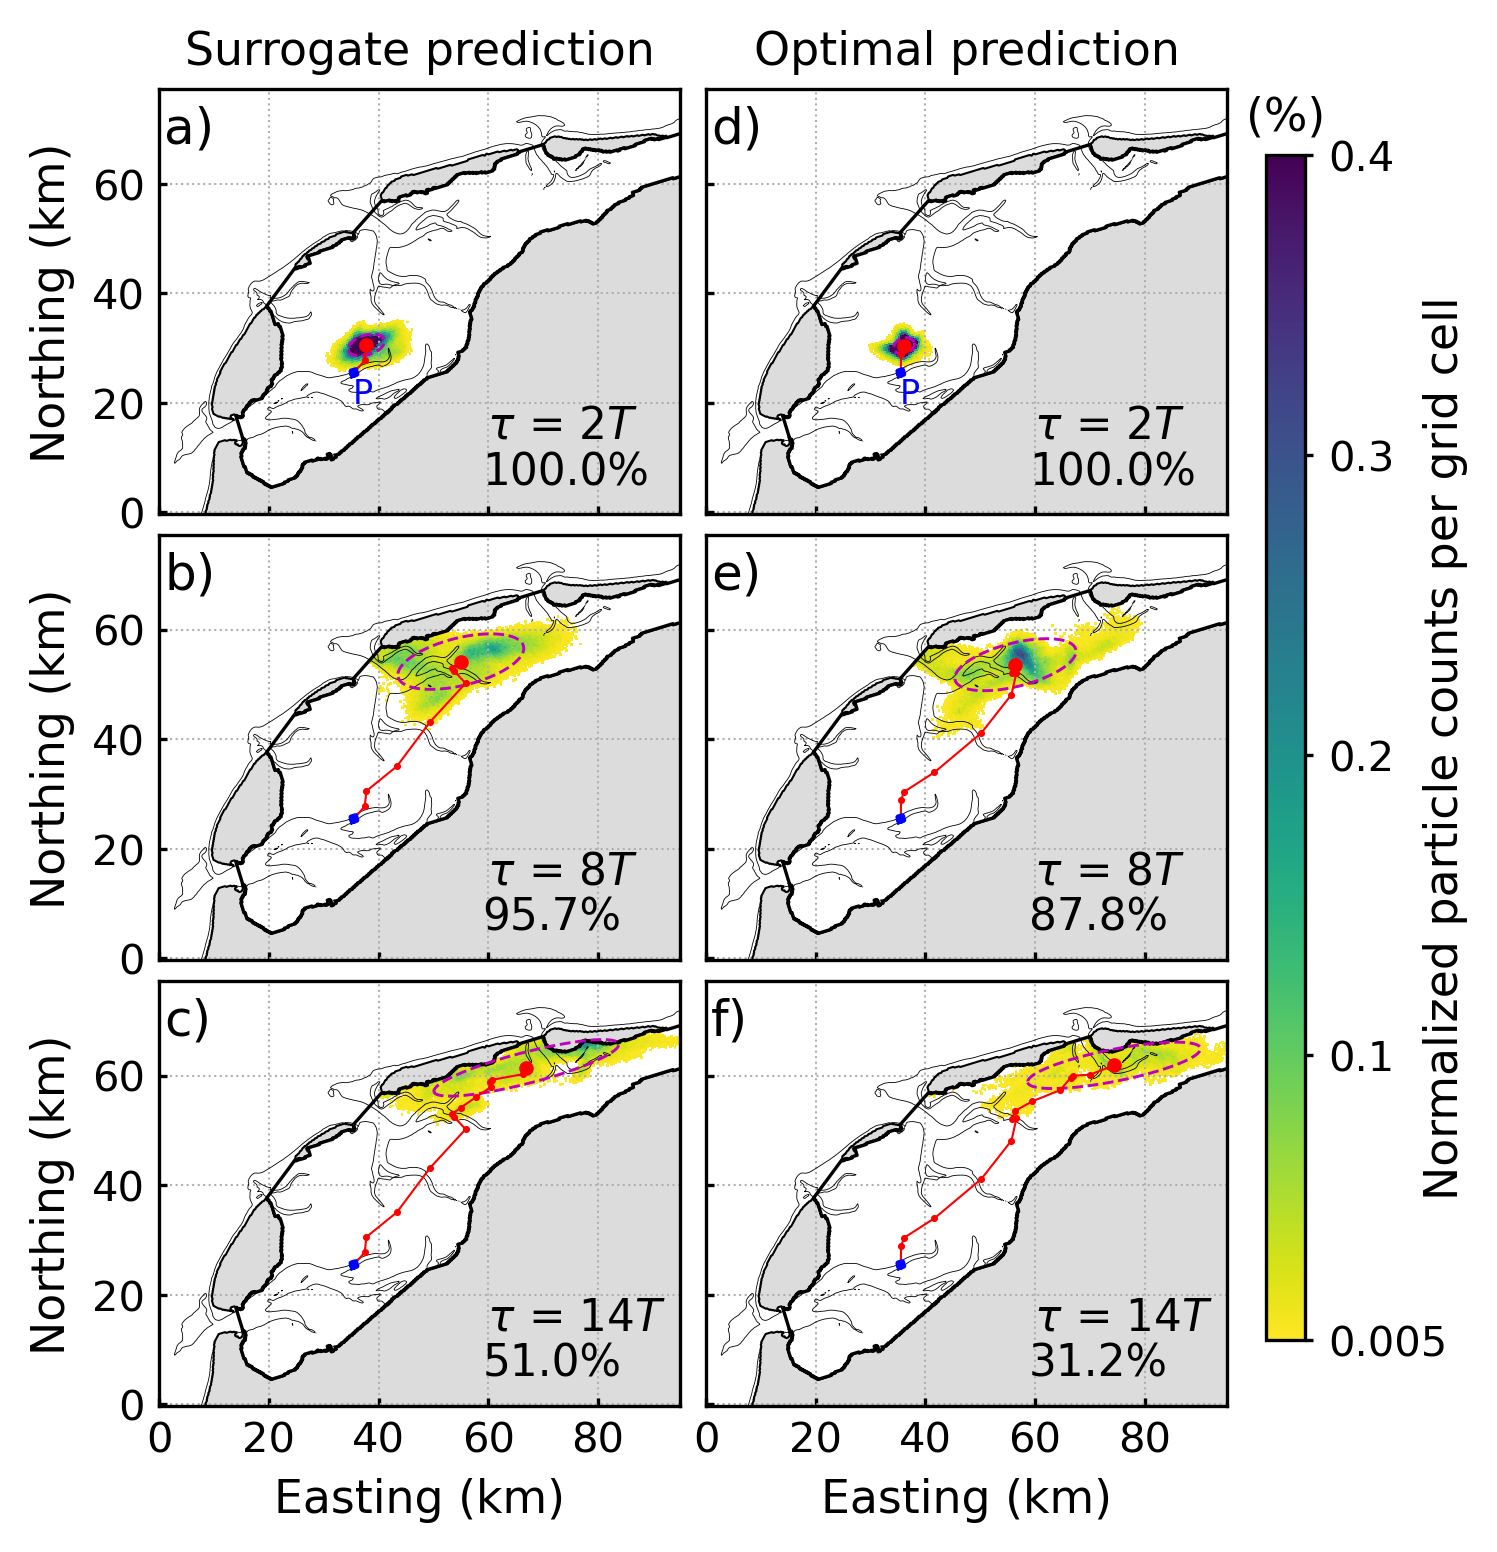

In [18]:
tt=[2,2,8,8,14,14]
lab0=['a)','d)','b)','e)','c)','f)']
#
fig,ax0=plt.subplots(3,2,figsize=(5.6,5.7),dpi=300, gridspec_kw={'wspace':0.05,'hspace':0.05})
axs=[]
for i in range(6):
    if i in [0,2,4]:
        dsst=dst_surrogate_pred; inout=ds_inout_particles_surrogate_pred.inout_particles; dss=ds_stats_surrogate_pred
        if i==0: 
            ax=ax0[0,0]
            xi=dsst.x.isel(obs=0).values; yi=dsst.y.isel(obs=0).values
            xxi=[xi[0],xi[-1],xi[-1],xi[0],xi[0]]; yyi=[yi[0],yi[0],yi[-1],yi[-1],yi[0]]
            _,_,xyip,_,_=transform_coordinates(ds_topography,np.array((xxi,yyi)).T*1.,xx,yy)
        if i==2: ax=ax0[1,0]
        if i==4: ax=ax0[2,0]
        lab1="Surrogate prediction"
    else:
        dsst=dst_optimal_pred; inout=ds_inout_particles_optimal_pred.inout_particles; dss=ds_stats_optimal_pred
        if i==1: ax=ax0[0,1]
        if i==3: ax=ax0[1,1]
        if i==5: ax=ax0[2,1]
        lab1="Optimal prediction"
    #background map---
    ax.pcolormesh(xctp,yctp,ds_topography.bathymetry,vmin=-2,vmax=32,cmap=cmap_land,shading='auto',rasterized=True)
    ax.contour(xctp,yctp,mask,levels=[0],linewidths=.5,colors='k')
    ax.plot(boundaries_dwsp[:,0],boundaries_dwsp[:,1],ls='-',color='k',lw=.8,markersize=0)
    ax.contour(xctp,yctp,ds_topography.bathymetry,levels=[5],linewidths=.2,colors='k')
    #hist---
    varx=(dsst.x.isel(obs=tt[i])*inout.isel(obs=tt[i])).values
    vary=(dsst.y.isel(obs=tt[i])*inout.isel(obs=tt[i])).values
    hist,nn=binning_particles(varx,vary,xedges,yedges)
    val=(hist/num_particles_initial*100)
    per=np.round(np.nansum(val),1) #per of particles inside
    minval=0.005
    val[val<minval]=np.nan 
    aa=ax.pcolormesh(xgridp,ygridp,val,vmin=minval,vmax=0.4,cmap='viridis_r') 
    #cm---
    cmx,cmy=dss.cmx,dss.cmy
    _,_,xycmp,_,_=transform_coordinates(ds_topography,np.array((cmx,cmy)).T*1.,xx,yy)
    #dispersion elipse around cm---
    x0=xycmp[tt[i],0];y0=xycmp[tt[i],1]
    disp=np.array([[dss.dispxx[tt[i]],dss.dispxy[tt[i]]],
                 [dss.dispxy[tt[i]],dss.dispyy[tt[i]]]])/1e6
    eigval,eigvec=np.linalg.eig(disp)
    #order with first max eigenval
    ii=np.argsort(eigval)[::-1] 
    eigval=eigval[ii]**.5*np.sqrt(2); eigvec=eigvec[:,ii]
    #rotate the points 
    theta = np.arctan2(eigvec[1,0],eigvec[0,0]) #angle of max eigenvector with x-GETM-axis
    theta_dws=17*np.pi/180
    if theta<0: theta+=np.pi
    ang=np.arange(0,361,1)
    x = x0 + eigval[0]*np.cos(ang*np.pi/180)*np.cos(theta+theta_dws) - eigval[1]*np.sin(ang*np.pi/180)*np.sin(theta+theta_dws)
    y = y0 + eigval[0]*np.cos(ang*np.pi/180)*np.sin(theta+theta_dws) + eigval[1]*np.sin(ang*np.pi/180)*np.cos(theta+theta_dws)
    ax.plot(x,y,'--m',lw=0.7)
    #cm
    ax.plot(xycmp[np.arange(tt[i]+1),0],xycmp[np.arange(tt[i]+1),1],'-r',lw=.5)
    ax.plot(xycmp[np.arange(tt[i]+1),0][1:],xycmp[np.arange(tt[i]+1),1][1:],'-or',lw=0,ms=.7)
    ax.plot(xycmp[tt[i],0],xycmp[tt[i],1],'or',ms=2.5)
    ax.plot(xyip[:,0],xyip[:,1],'-b',lw=1.3)
    if i<2: ax.text(xyip[0,0],xyip[0,1]-5,'P',c='b',fontsize=8)
    #
    ax.grid(linewidth=0.5,ls=':')
    yticks=np.arange(540,640,20); ax.set_yticks(yticks)
    xticks=np.arange(100,240,20); ax.set_xticks(xticks);ax.set_xticklabels(xticks-100);
    ax.axis('equal'); 
    ax.axis([100,195,540,617]);
    ax.tick_params(direction="in")
    if i in [0,2,4]:
        ax.set_ylabel('Northing (km)');ax.set_yticklabels(yticks-540); ax.set_xticklabels("");
    if i in [1,3,5]: ax.set_xticklabels(""); ax.set_yticklabels("");
    if i>3: ax.set_xticklabels(xticks-100); ax.set_xlabel('Easting (km)');
    ax.text(.01,0.875,f"{lab0[i]}", transform=ax.transAxes, fontsize=glob_font_size+1)
    if i<2: ax.set_title(lab1)
    ax.text(.605,0.18,r" $\tau$" + f" = {tt[i]}$T$", transform=ax.transAxes, fontsize=glob_font_size-.5)        
    ax.text(.62,0.07,f"{per}%", transform=ax.transAxes, fontsize=glob_font_size-.5)
    axs+=[ax]
    if i==5:
        cticks=np.arange(0,0.5,0.1); cticks[0]=minval
        cticks_lab=[f"{i:.1f}" for i in cticks]; cticks_lab[0]=str(minval)
        cbar=fig.colorbar(aa,ax=axs,ticks=cticks,aspect=30,pad=0.03,shrink=.9); #cbar.ax.set_ylabel("(km)")
        cbar.ax.set_yticklabels(cticks_lab)
        cbar.ax.set_title(label="(%)");
        cbar.set_label("Normalized particle counts per grid cell", labelpad=-6);
print("time deployment: ",str(time_deployment[0])[:19])
#
fig_name=f'spatial_concentration_particles_surrogate_and_optimal_predictions_{str(time_deployment[0])[:19]}'
fig.savefig(f'{dir_main}{dir_repo}{dir_figures}{fig_name}.jpg',bbox_inches='tight',pad_inches=0.1,dpi=600)